In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import seaborn as sns
sns.set(style="whitegrid")

In [225]:
admission = pd.read_csv('ADMISSIONS.csv')
admission.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [226]:
def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by df categorical series name 
    '''
    results = admission[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();
# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    ''' 
    Boxplot of LOS by df categorical series name 
    '''
    results = admission[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(admission['LOS'].loc[admission[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();



In [227]:
admission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
ROW_ID                  58976 non-null int64
SUBJECT_ID              58976 non-null int64
HADM_ID                 58976 non-null int64
ADMITTIME               58976 non-null object
DISCHTIME               58976 non-null object
DEATHTIME               5854 non-null object
ADMISSION_TYPE          58976 non-null object
ADMISSION_LOCATION      58976 non-null object
DISCHARGE_LOCATION      58976 non-null object
INSURANCE               58976 non-null object
LANGUAGE                33644 non-null object
RELIGION                58518 non-null object
MARITAL_STATUS          48848 non-null object
ETHNICITY               58976 non-null object
EDREGTIME               30877 non-null object
EDOUTTIME               30877 non-null object
DIAGNOSIS               58951 non-null object
HOSPITAL_EXPIRE_FLAG    58976 non-null int64
HAS_CHARTEVENTS_DATA    58976 non-null int64
dtypes: int64(5), objec

In [228]:
# Missing value percentage of every column
admission.isnull().sum() * 100/admission.shape[0]

ROW_ID                   0.000000
SUBJECT_ID               0.000000
HADM_ID                  0.000000
ADMITTIME                0.000000
DISCHTIME                0.000000
DEATHTIME               90.073928
ADMISSION_TYPE           0.000000
ADMISSION_LOCATION       0.000000
DISCHARGE_LOCATION       0.000000
INSURANCE                0.000000
LANGUAGE                42.953066
RELIGION                 0.776587
MARITAL_STATUS          17.173087
ETHNICITY                0.000000
EDREGTIME               47.644805
EDOUTTIME               47.644805
DIAGNOSIS                0.042390
HOSPITAL_EXPIRE_FLAG     0.000000
HAS_CHARTEVENTS_DATA     0.000000
dtype: float64

In [229]:
# drop uesless columns, 
# 'EDREGTIME', 'EDOUTTIME' -- emergency enter and exit time, drop since missing too much 
admission.drop(columns=['ROW_ID','EDREGTIME', 'EDOUTTIME', 'DEATHTIME', 'LANGUAGE'], inplace=True)

# 1.LOS

In [230]:
#### Calculte LOS ####
# Convert admission and discharge times to datatime type
admission['ADMITTIME'] = pd.to_datetime(admission['ADMITTIME'])
admission['DISCHTIME'] = pd.to_datetime(admission['DISCHTIME'])

# Convert timedelta type into float 'days', 86400 seconds in a day
admission['LOS'] = (admission['DISCHTIME'] - admission['ADMITTIME']).dt.total_seconds()/86400

In [231]:
admission['LOS'].describe()

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

In [232]:
admission['LOS'][admission['LOS'] < 0].describe()

count    98.000000
mean     -0.290072
std       0.221997
min      -0.945139
25%      -0.412500
50%      -0.247222
75%      -0.108681
max      -0.000694
Name: LOS, dtype: float64

In [233]:
# Exclude data with los lower than 0
admission = admission[admission['LOS'] > 0]

In [234]:
admission['LOS'].describe()

count    58878.000000
mean        10.151266
std         12.459774
min          0.001389
25%          3.755556
50%          6.489583
75%         11.805556
max        294.660417
Name: LOS, dtype: float64

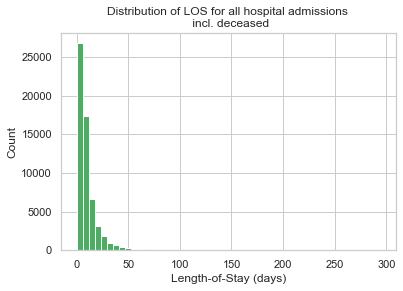

In [235]:
# Plot LOS Distribution
plt.hist(admission['LOS'], bins=50, color = '#55a868')
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

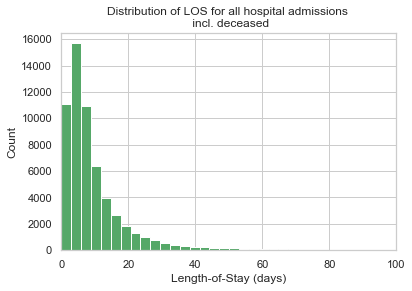

In [236]:
# Plot LOS Distribution
plt.hist(admission['LOS'], bins=100, color = '#55a868')
plt.xlim(0, 100)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [237]:
admission['LOS'][admission['LOS'] <= 50].describe()

count    57832.000000
mean         8.972622
std          8.214166
min          0.001389
25%          3.710417
50%          6.332639
75%         11.278472
max         49.935417
Name: LOS, dtype: float64

In [238]:
# Only few patients stay in ICU longer than 50 days. (1.77% amony all the admissions)
admission['LOS'][admission['LOS'] > 50].describe()

count    1046.000000
mean       75.317021
std        26.178524
min        50.002083
25%        56.536806
50%        66.864931
75%        85.888194
max       294.660417
Name: LOS, dtype: float64

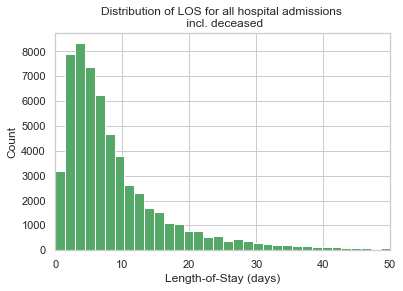

In [239]:
# Plot LOS Distribution
plt.hist(admission['LOS'], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [240]:
admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,0,1,1.144444
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5.496528
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,0,1,6.768056
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,0,1,2.856944
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,0,1,3.534028


# 2.Died

In [241]:
# Died cases' LOS 
admission['LOS'][admission['HOSPITAL_EXPIRE_FLAG'] == 1].describe()

count    5774.000000
mean       10.271681
std        13.969958
min         0.001389
25%         1.965278
50%         5.917014
75%        13.071875
max       206.425694
Name: LOS, dtype: float64

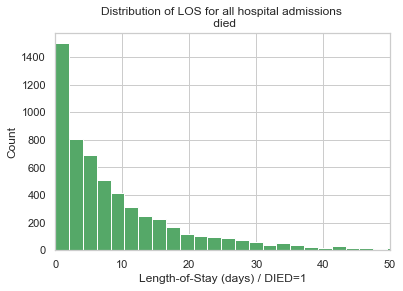

In [242]:
# Plot LOS Distribution -- High portion in the first bin
plt.hist(admission['LOS'][admission['HOSPITAL_EXPIRE_FLAG']==1], bins=100, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n died')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days) / DIED=1')
plt.tick_params(top=False, right=False) 
plt.show();

In [243]:
# Not died cases' LOS 
admission['LOS'][admission['HOSPITAL_EXPIRE_FLAG'] == 0].describe()

count    53104.000000
mean        10.138174
std         12.284461
min          0.014583
25%          3.866667
50%          6.565972
75%         11.711632
max        294.660417
Name: LOS, dtype: float64

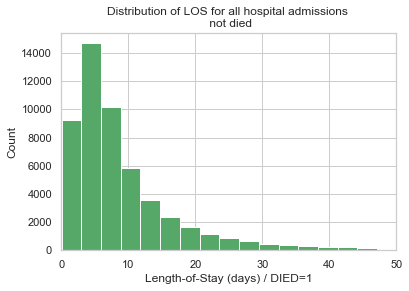

In [244]:
# Plot LOS Distribution -- highest portion in the third bin
plt.hist(admission['LOS'][admission['HOSPITAL_EXPIRE_FLAG'] == 0], bins=100, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n not died')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days) / DIED=1')
plt.tick_params(top=False, right=False) 
plt.show();

#### ？？？？？？？？？？ hypothesis test: lower mortality rate could cause shorter length of stay, 
#### how equal between los and death time
#### when some new data comes in, we could estimate the mortality rate, and then use this to 
#### estimate the probabilty of LOS < 2(or 1, 1 is more reasonable since the above plot)
#### when estimate the length of stay, should separte into two models, low mortality/ high mortality

# 3. Admission Type

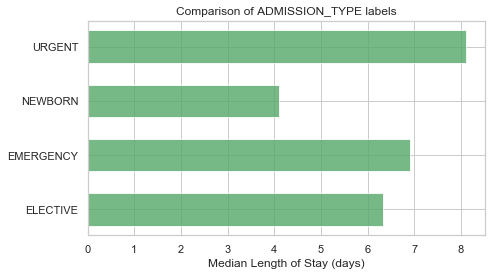

In [245]:
plot_los_groupby('ADMISSION_TYPE') # urgent tends to longer, newborn shorter, emergency&elective are similar

In [246]:
admission = admission[admission['ADMISSION_TYPE'] != 'NEWBORN'] # the age of NEWBORNs are < 15

In [247]:
# Count the number of admission types
admission.groupby('ADMISSION_TYPE')['SUBJECT_ID'].nunique()

ADMISSION_TYPE
ELECTIVE      7263
EMERGENCY    32544
URGENT        1306
Name: SUBJECT_ID, dtype: int64

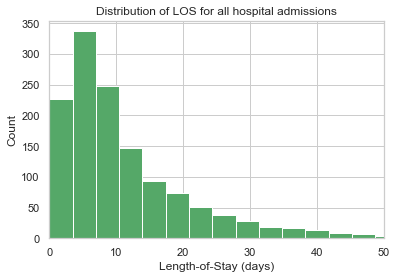

In [248]:
# Plot LOS Distribution -- 
plt.hist(admission['LOS'][admission['ADMISSION_TYPE'] == 'URGENT'], bins=50, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

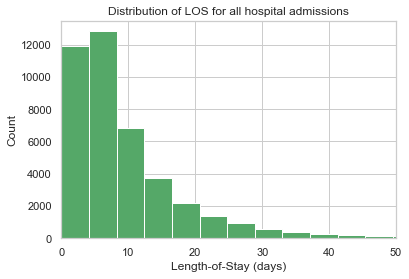

In [249]:
plt.hist(admission['LOS'][admission['ADMISSION_TYPE'] == 'EMERGENCY'], bins=50, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

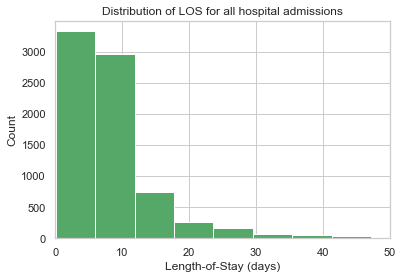

In [252]:
plt.hist(admission['LOS'][admission['ADMISSION_TYPE'] == 'ELECTIVE'], bins=50, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

### want a barchart that could show: mortality rate and admission type and los 

# 4. ADMISSION_LOCATION

In [253]:
admission.groupby('ADMISSION_LOCATION')['SUBJECT_ID'].nunique()

ADMISSION_LOCATION
** INFO NOT AVAILABLE **         4
CLINIC REFERRAL/PREMATURE     8553
EMERGENCY ROOM ADMIT         17935
HMO REFERRAL/SICK                1
PHYS REFERRAL/NORMAL DELI     8783
TRANSFER FROM HOSP/EXTRAM     7978
TRANSFER FROM OTHER HEALT       68
TRANSFER FROM SKILLED NUR      259
TRSF WITHIN THIS FACILITY        5
Name: SUBJECT_ID, dtype: int64

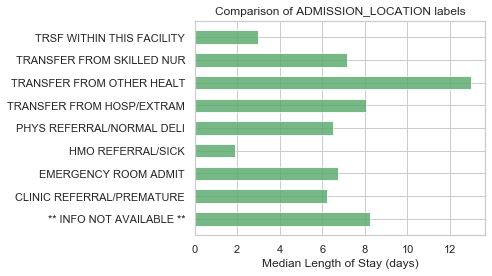

In [254]:
# admission.groupby('ADMISSION_LOCATION')['LOS'].mean()
plot_los_groupby('ADMISSION_LOCATION')  # ????????????? I want this with moratlity 

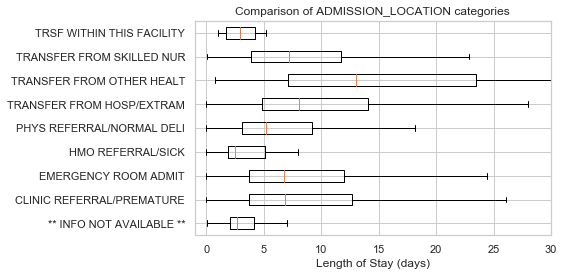

In [186]:
boxplot_los_groupby('ADMISSION_LOCATION') # try to regression with different location

# 5. DISCHARGE_LOCATION

In [187]:
admission.groupby('DISCHARGE_LOCATION')['SUBJECT_ID'].nunique()

DISCHARGE_LOCATION
DEAD/EXPIRED                  5741
DISC-TRAN CANCER/CHLDRN H      635
DISC-TRAN TO FEDERAL HC         11
DISCH-TRAN TO PSYCH HOSP       419
HOME                         17011
HOME HEALTH CARE             12294
HOME WITH HOME IV PROVIDR       63
HOSPICE-HOME                   400
HOSPICE-MEDICAL FACILITY       153
ICF                             45
LEFT AGAINST MEDICAL ADVI      303
LONG TERM CARE HOSPITAL       1926
OTHER FACILITY                  59
REHAB/DISTINCT PART HOSP      5775
SHORT TERM HOSPITAL           1504
SNF                           6606
SNF-MEDICAID ONLY CERTIF         1
Name: SUBJECT_ID, dtype: int64

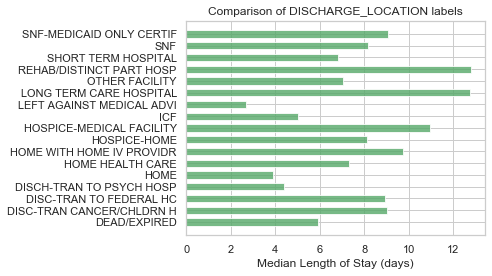

In [188]:
plot_los_groupby('DISCHARGE_LOCATION') # # ????????????? I want this with moratlity 

# 6.INSURANCE

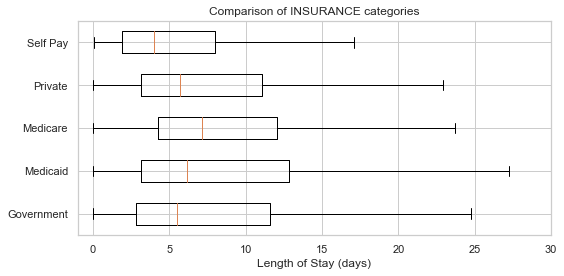

In [189]:
boxplot_los_groupby('INSURANCE')

# 7. RELIGION

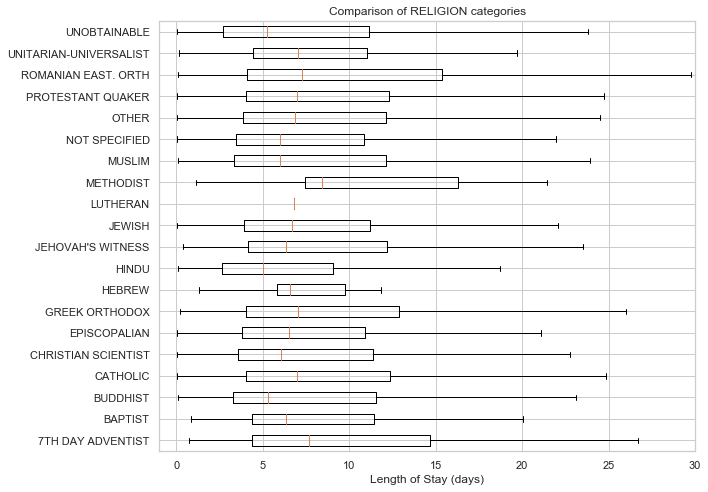

In [190]:
boxplot_los_groupby('RELIGION',  size=(10,7))

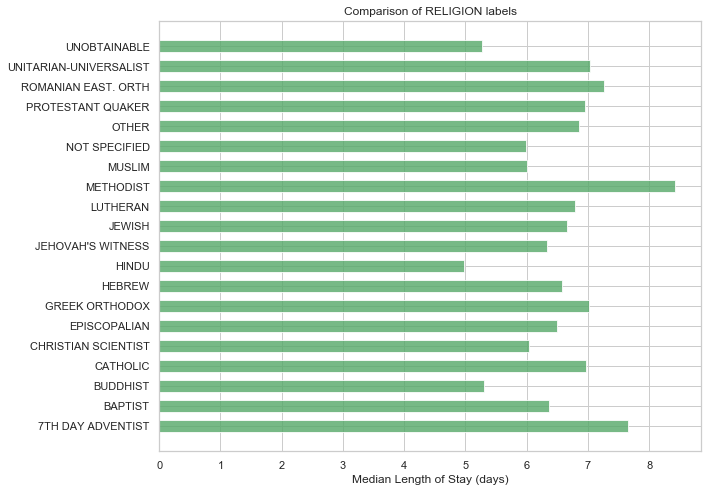

In [191]:
plot_los_groupby('RELIGION', size=(10,7))

In [192]:
admission['RELIGION'] = admission['RELIGION'].fillna('Unobtainable')
print('{} % Unobtainable'.format(
    admission['RELIGION'].value_counts()['UNOBTAINABLE']/len(admission['RELIGION']) * 100))
print('{} % Not Specified'.format(
    admission['RELIGION'].value_counts()['NOT SPECIFIED']/len(admission['RELIGION']) * 100))

13.998437446924147 % Unobtainable
19.93613913516084 % Not Specified


#### ???you add a dump value that if the religion is un&nots, or if the religion is methodist

# 8. MARITAL_STATUS

In [193]:
admission['MARITAL_STATUS'] = admission['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')

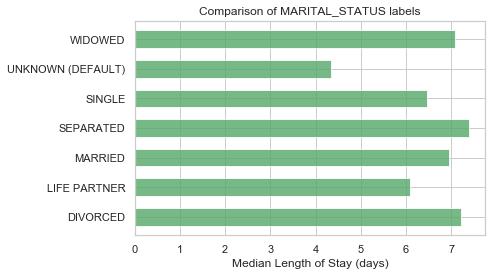

In [194]:
plot_los_groupby('MARITAL_STATUS')

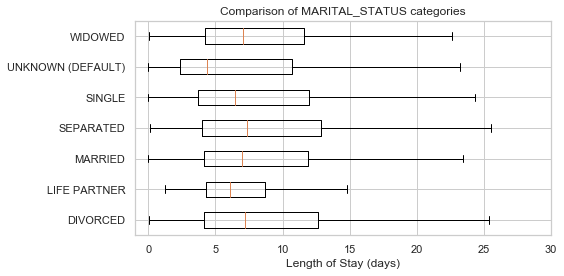

In [195]:
boxplot_los_groupby('MARITAL_STATUS')

#### could convert it into single or not single

# 9. ETHNICITY

In [196]:
admission.groupby('ETHNICITY')['LOS'].median()

ETHNICITY
AMERICAN INDIAN/ALASKA NATIVE                                7.906944
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE    15.660417
ASIAN                                                        4.355903
ASIAN - ASIAN INDIAN                                         6.833333
ASIAN - CAMBODIAN                                            9.056250
ASIAN - CHINESE                                              5.357639
ASIAN - FILIPINO                                             4.443750
ASIAN - JAPANESE                                             3.872917
ASIAN - KOREAN                                               7.015972
ASIAN - OTHER                                                9.764583
ASIAN - THAI                                                 6.659722
ASIAN - VIETNAMESE                                           6.169444
BLACK/AFRICAN                                                6.175694
BLACK/AFRICAN AMERICAN                                       6.145833
BLACK/CAPE

In [197]:
admission['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
admission['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
admission['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
admission['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
admission['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
# admission['ETHNICITY'].loc[~admission['ETHNICITY'].isin(admission['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
admission['ETHNICITY'].value_counts()

WHITE                                                       41268
OTHER/UNKNOWN                                                7377
BLACK/AFRICAN AMERICAN                                       5779
HISPANIC/LATINO                                              2125
ASIAN                                                        2006
MULTI RACE ETHNICITY                                          130
PORTUGUESE                                                     61
AMERICAN INDIAN/ALASKA NATIVE                                  51
MIDDLE EASTERN                                                 43
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER                      18
CARIBBEAN ISLAND                                                9
SOUTH AMERICAN                                                  8
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE        3
Name: ETHNICITY, dtype: int64

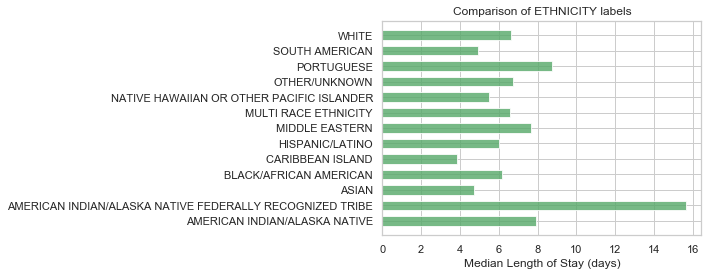

In [198]:
plot_los_groupby('ETHNICITY', size=(10,4))

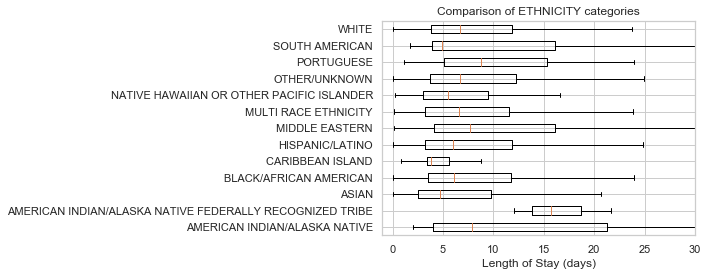

In [199]:
boxplot_los_groupby('ETHNICITY', size=(10,4))

#### ????????caribbean island has the lowest median ... , maybe you should have a dummy variable, and lower the number of type

# 10. DIAGNOSIS

In [200]:
admission.groupby('DIAGNOSIS')['LOS'].median() # this is just the shortlist of patient resond to admission/ exclude 

DIAGNOSIS
        MITRAL STENOSIS\MITRAL VALVE REPLACEMENT /SDA     4.277778
   DUODENAL MASS/SDA                                     26.122917
 ? SEROTONIN SYNDROME                                     7.028472
 ABDOMINAL AORTIC ANEURYSM/SDA                           34.187500
 ABSENCE/SDA                                              6.165972
                                                           ...    
WOUND ULCER                                              16.527778
ZENKER'S DIVERTICULUM/SDA                                11.395486
ZONE 2 NECK INJURY                                        1.095139
ZOSTER VS. MENINGITIS                                     2.925000
ZYGOMATIC FRACTURE LEFT                                   2.851389
Name: LOS, Length: 15674, dtype: float64

In [201]:
admission.to_csv('temp_admission.csv')

# Diagnosis_ICD

In [218]:
diagnosis = pd.read_csv("DIAGNOSES_ICD.csv")
diagnosis.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [219]:
diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
ROW_ID        651047 non-null int64
SUBJECT_ID    651047 non-null int64
HADM_ID       651047 non-null int64
SEQ_NUM       651000 non-null float64
ICD9_CODE     651000 non-null object
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [220]:
# Missing value percentage of every column
diagnosis.isnull().sum() * 100/diagnosis.shape[0]

ROW_ID        0.000000
SUBJECT_ID    0.000000
HADM_ID       0.000000
SEQ_NUM       0.007219
ICD9_CODE     0.007219
dtype: float64

In [221]:
diagnosis = diagnosis.dropna(subset=['ICD9_CODE'])

In [222]:
# replace code start with E & V to 999
diagnosis['code'] = diagnosis['ICD9_CODE']
diagnosis['code'] = diagnosis['code'][~diagnosis['code'].str.contains("[a-zA-Z]")]
diagnosis['code'].fillna(value='999', inplace=True)

diagnosis['code'] = diagnosis['code'].str.slice(start=0, stop=3, step=1)
diagnosis['code'] = diagnosis['code'].astype(int)
diagnosis.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,code
0,1297,109,172335,1.0,40301,403
1,1298,109,172335,2.0,486,486
2,1299,109,172335,3.0,58281,582
3,1300,109,172335,4.0,5855,585
4,1301,109,172335,5.0,4254,425


In [223]:
# ICD-9 Category ranges
icd9_dict = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_dict):
    diagnosis['code'] = np.where(diagnosis['code'].between(cat_range[0], cat_range[1]), num, diagnosis['code'])
    
# Convert integer to category name using diag_dict
diagnosis['categories'] = diagnosis['code'].replace(diag_dict)
diagnosis.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,code,categories
0,1297,109,172335,1.0,40301,6,circulatory
1,1298,109,172335,2.0,486,7,respiratory
2,1299,109,172335,3.0,58281,9,genitourinary
3,1300,109,172335,4.0,5855,9,genitourinary
4,1301,109,172335,5.0,4254,6,circulatory


In [256]:
admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,0,1,1.144444
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5.496528
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,0,1,6.768056
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,0,1,2.856944
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,0,1,3.534028


In [257]:
train_df = admission[['HADM_ID', 'LOS', 'HOSPITAL_EXPIRE_FLAG']]
train_df.to_csv('train.csv')

,HADM_ID,LOS,HOSPITAL_EXPIRE_FLAG
0,165315,1.144444,0
1,152223,5.496528,0
2,124321,6.768056,0
3,161859,2.856944,0
4,129635,3.534028,0


In [258]:
hr_df = pd.read_csv('temp220045.csv')
hr_df.head()

,11743639,2105-04-18 02:00:00.000+0000,171985,52861,77,bpm
0,182194520,2136-12-07 06:00:00.000+0000,144979,29948,68.0,BPM
1,22845230,2105-01-05 13:00:00.000+0000,158328,75194,83.0,bpm
2,5459243,2123-04-27 15:00:00.000+0000,100456,40526,106.0,bpm
3,19507687,2154-06-06 03:20:00.000+0000,120967,67112,112.0,bpm
4,29020962,2184-07-14 15:00:00.000+0000,128732,88953,59.0,bpm
